- Question we want to answer: How likely is a person to suffer from heart failure based on their pre-existing conditions as per the columns of our dataset.
- We are analyzing this dataset for the potential benefit of the healthcare industry
- It would also enable us to raise awareness about how people might be in danger of this plight.
- We can use the data to train a bot that regular people could use to get a better understanding of their own standing in regards to this

Data retrieval and wrangling: we want to be able to use this data and apply a knn model to determine the likeliness of a death event to the patient based on their body levels of (variables to be decided). Patients are individuals in an age range of 40-95 years

In [13]:
library(tidyverse)
library(tidymodels)
library(repr)

In [14]:
set.seed(69420)
heart_data_raw <- read_csv("https://raw.githubusercontent.com/SaadRehmanCS/DSCI_project/master/heart_failure_clinical_records_dataset.csv") %>%
                mutate(DEATH_EVENT = as_factor(DEATH_EVENT)) %>%
                rename(death_event = DEATH_EVENT) 

heart_data_condition <- heart_data_raw %>%
                pivot_longer(cols=c(anaemia, diabetes, high_blood_pressure), names_to="medical_condition", values_to="patient_has_it") %>%
                filter(patient_has_it == 1, medical_condition != "anaemia") %>%
                select(-patient_has_it, -medical_condition, -time, -sex, -smoking) 

heart_data <- heart_data_condition %>%
            filter(creatinine_phosphokinase < 1500)

heart_data_split <- initial_split(heart_data, prop = 0.75, strata = death_event)
heart_data_train <- training(heart_data_split)
heart_data_test <- testing(heart_data_split)

head(heart_data_train)


Parsed with column specification:
cols(
  age = col_double(),
  anaemia = col_double(),
  creatinine_phosphokinase = col_double(),
  diabetes = col_double(),
  ejection_fraction = col_double(),
  high_blood_pressure = col_double(),
  platelets = col_double(),
  serum_creatinine = col_double(),
  serum_sodium = col_double(),
  sex = col_double(),
  smoking = col_double(),
  time = col_double(),
  DEATH_EVENT = col_double()
)



age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,death_event
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
60,315,60,454000,1.1,131,1
80,123,35,388000,9.4,133,1
75,81,38,368000,4.0,131,1
49,80,30,427000,1.0,138,0
70,125,25,237000,1.0,140,1
48,582,55,87000,1.9,121,1


We have now cleaned the data so it only includes patients who are already suffering from diabetes and high blood pressure. Next, we want to determine which variables have the greatest influence on death_event, and only use those variables in our actual knn model. We will do this by plotting facetted boxplots



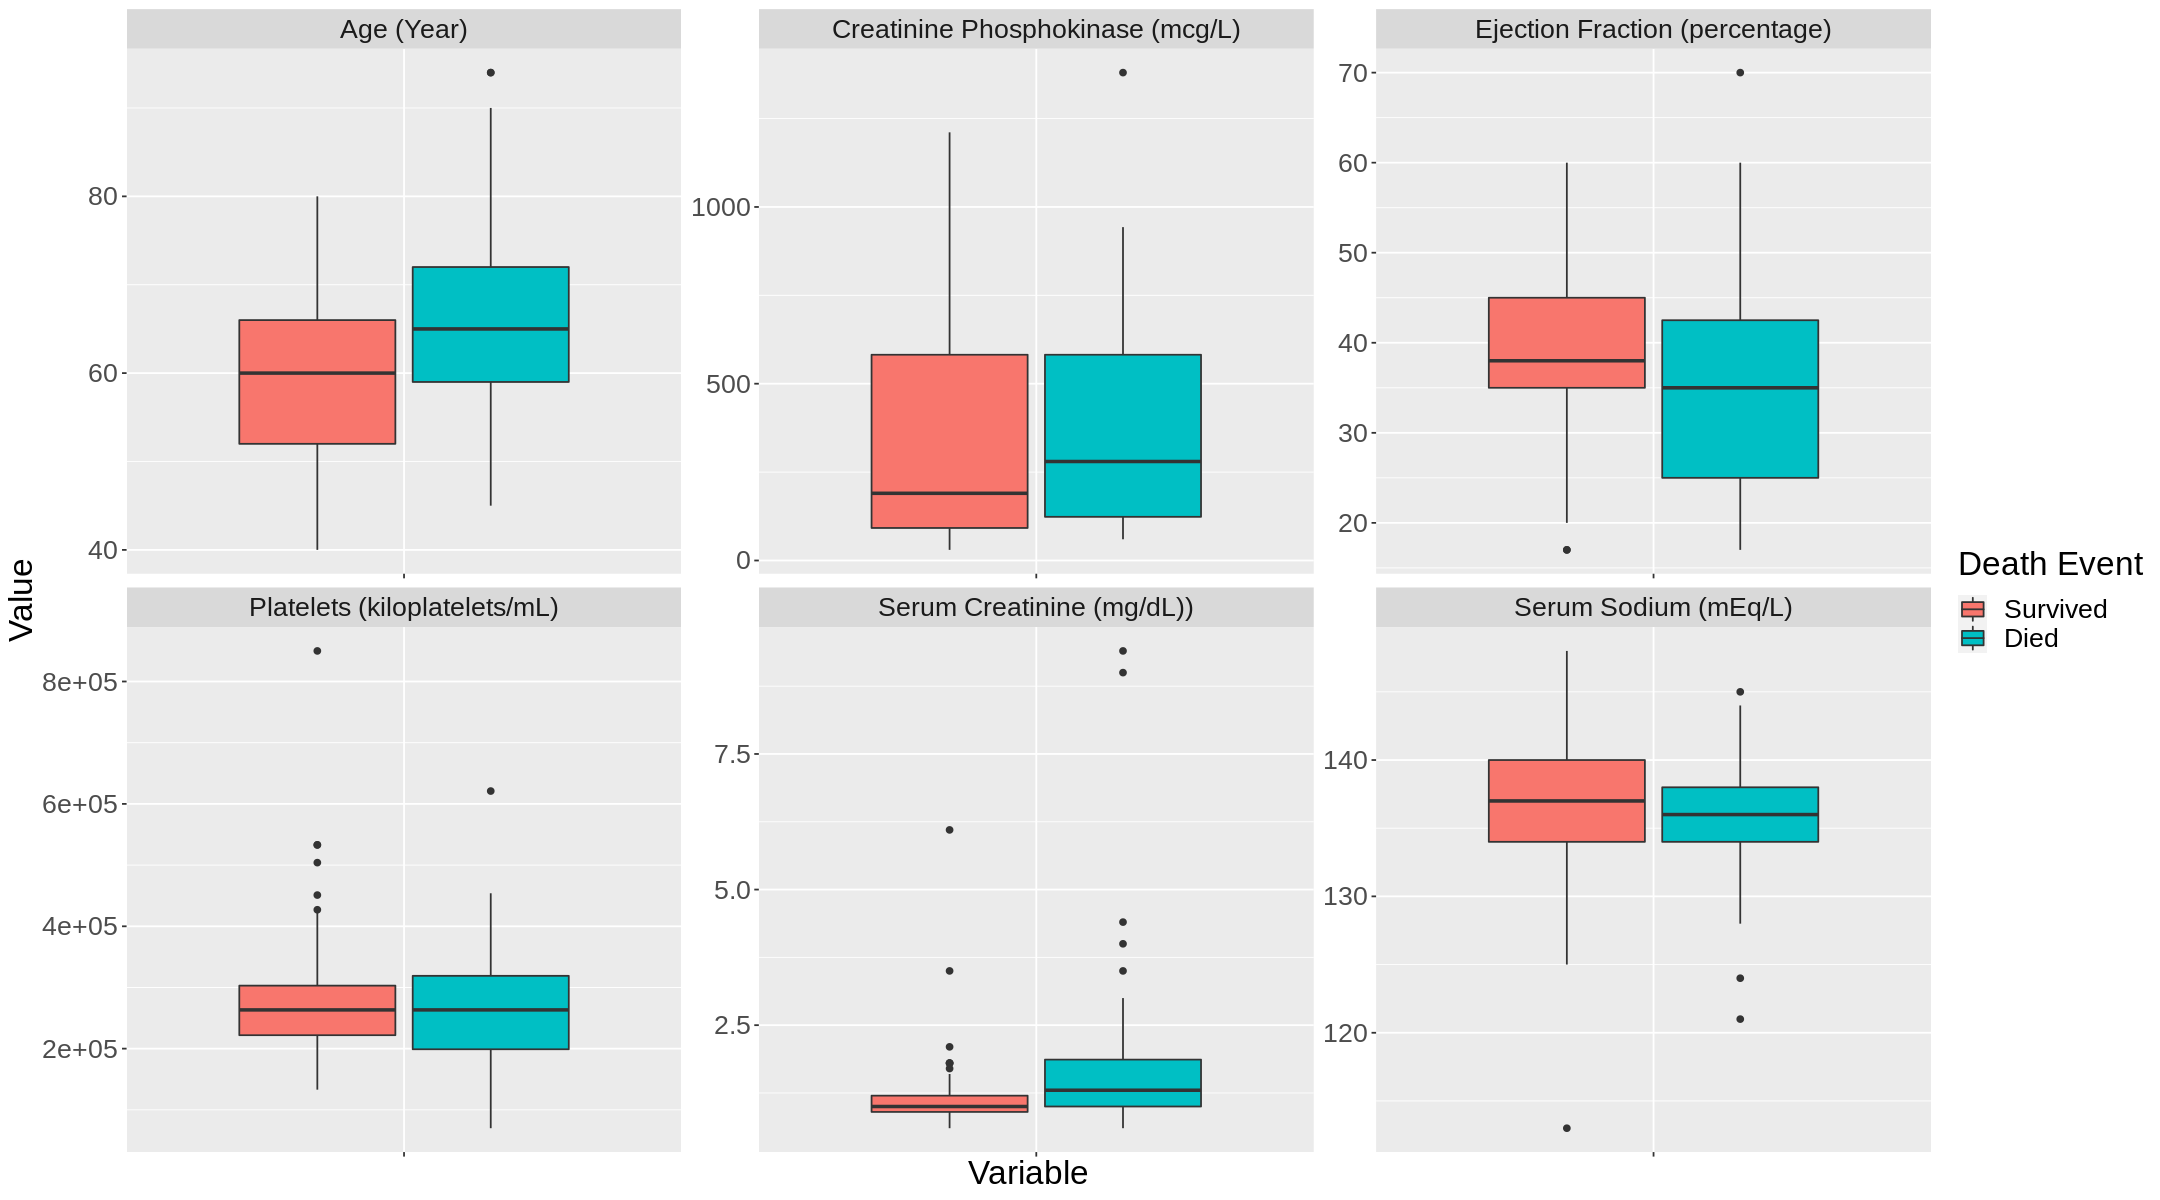

In [15]:
options(repr.plot.width = 18, repr.plot.height = 10)   # resize the shape

# source:
# https://stackoverflow.com/questions/3472980/how-to-change-facet-labels
variable_names <- c(
                    age = "Age (Year)",
                    creatinine_phosphokinase = "Creatinine Phosphokinase (mcg/L)",
                    ejection_fraction = "Ejection Fraction (percentage)",
                    platelets = "Platelets (kiloplatelets/mL)",
                    serum_creatinine = "Serum Creatinine (mg/dL))",
                    serum_sodium = "Serum Sodium (mEq/L)"
                    )

pivoted_heart_data <- heart_data_train %>% 
                    pivot_longer(cols=c(age:serum_sodium), names_to="variable", values_to="value") 

# source: 
# https://stackoverflow.com/questions/14604439/plot-multiple-boxplot-in-one-graph
heart_data_boxplot <- pivoted_heart_data %>% # all variables are merged in two columns one for the names and the other for values
                    ggplot(aes(x=variable, y=value)) +
                    geom_boxplot(aes(fill=death_event)) + 
                    facet_wrap( ~ variable, scales="free", labeller = as_labeller(variable_names))+    # boxplot them based on death_event
                    labs(x = "Variable", y = "Value") +
                    scale_fill_discrete(name = "Death Event", labels = c("Survived", "Died")) +         # legned name and values name
                    theme(text = element_text(size=20), axis.text.x = element_blank())                 # text size

# source:
# https://stackoverflow.com/questions/3261597/can-i-change-the-position-of-the-strip-label-in-ggplot-from-the-top-to-the-botto
# facet_wrap( ~ variable, scales="free", labeller = as_labeller(variable_names), strip.position="bottom") in case we want to change
#the position of the facet labels


heart_data_boxplot
options(repr.plot.width = NULL, repr.plot.height = NULL) 

From the figure above we can notice that there is no significant difference when comprsining the data of people who died and who survived in the *creatinine_phosphokinase* and *platelets*. Therefore, we will exclude these two variables from our predictors.

`summarise()` ungrouping output (override with `.groups` argument)



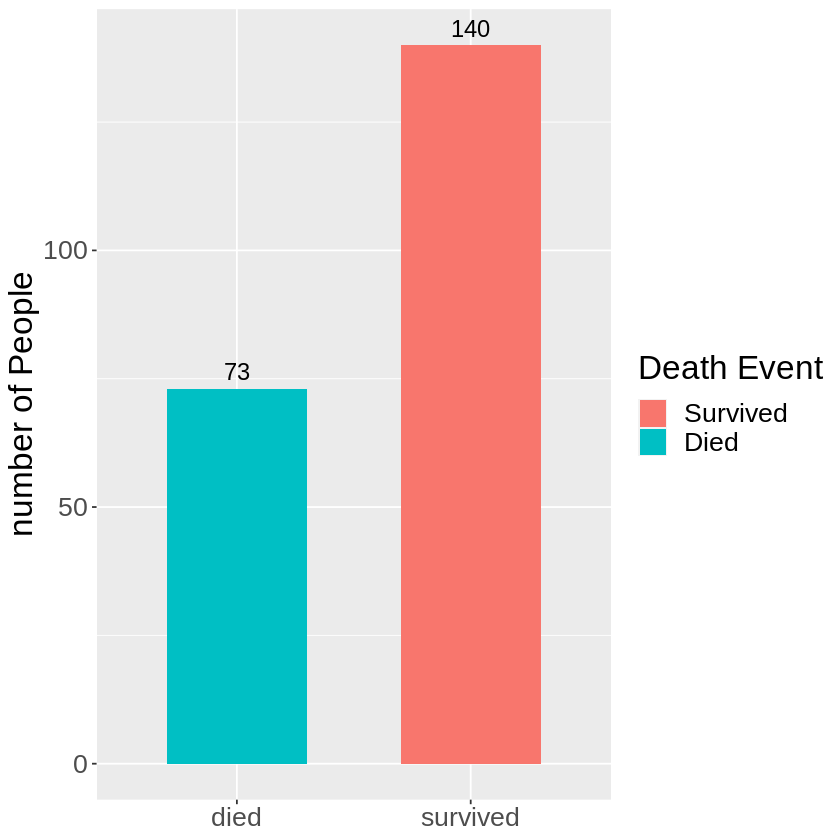

In [29]:
# Here is the summary of the dataframe:

summarized_heard_data <- pivoted_heart_data %>%
                        group_by(variable) %>%
                        summarize(min = min(value), max = max(value), mean = mean(value))  %>% 
                        pivot_longer(cols=c(min:mean), names_to="measure", values_to="value") %>%
                        mutate(value = round(value,digits=2)) %>%
                        mutate(anyNA = anyNA(variable)) %>%
                        filter(variable != "creatinine_phosphokinase", variable != "platelets")

#summarized_heard_data

death_event_column <- heart_data %>% select(death_event)
number_of_people <- c(death_event_column %>% filter(death_event == 0) %>% nrow(), death_event_column %>% filter(death_event == 1) %>% nrow())
death_event <- c("survived", "died")

df <- data.frame(death_event, number_of_people) 
#df

#death_event_summary_plot <- ggplot(df, aes(x=death_event, y=number_of_people, fill = death_event)) +
#                            geom_bar(stat="identity", width = 0.6) +
#                            labs(x = NULL, y = "number of People")  +
#                            scale_fill_manual(values = c("#00bfc4", "#f8766d"), name = "Death Event", labels = c("Died", "Survived")) +
#                            theme(text = element_text(size = 20)) +
#                            geom_text(aes(label=number_of_people), vjust=-0.5, size=5)

death_event_summary_plot <- ggplot(df, aes(x=death_event, y=number_of_people, fill = death_event)) +
                            geom_bar(stat="identity", width = 0.6) +
                            labs(x = NULL, y = "number of People")  +
                            scale_fill_manual(values = c("#00bfc4", "#f8766d"), name = "Death Event", labels = c("Died", "Survived")) +
                            theme(text = element_text(size = 20)) +
                            geom_text(aes(label=number_of_people), vjust=-0.5, size=5) +
                            guides(fill = guide_legend(reverse = TRUE))
       
       
death_event_summary_plot

Final predictors: age, serum_creatine, ejection_fraction, serum_sodium

In [17]:
heart_data_clean <- heart_data_train %>%
                    select(-creatinine_phosphokinase, -platelets)
heart_data_recipe <- recipe(death_event ~ ., data = heart_data_clean) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors()) %>%
            prep()

scaled_heart_data <- bake(heart_data_recipe, heart_data_train)
head(scaled_heart_data)


age,ejection_fraction,serum_creatinine,serum_sodium,death_event
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.1519780,1.86569060,-0.2495558,-1.1109707,1
1.6604256,-0.30687487,7.1331603,-0.6831601,1
1.2073247,-0.04616702,2.3299474,-1.1109707,1
-1.1487999,-0.74138797,-0.3385042,0.3863665,0
0.7542238,-1.17590106,-0.3385042,0.8141771,1
-1.2394201,1.43117750,0.4620313,-3.2500237,1


We will use scaled_heart_data as the training set for our knn model